In [1]:
import torch
import sys
import numpy as np
import cv2
from matplotlib import pyplot as plt

sys.path.append(r'/user/gr1/delphi/dghezzi/UNet')

from UNet import UNet, UNetWithAttention

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Crea istanza modello (deve avere la stessa architettura usata in training)
model = UNetWithAttention(in_channels=1, out_channels=1)
model.load_state_dict(torch.load("best_unet.pth", map_location=device))
model.to(device)
model.eval()  # modalità valutazione (disabilita dropout, batchnorm, ecc)

UNetWithAttention(
  (encoder1): DoubleConv(
    (block): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): DoubleConv(
    (block): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(i

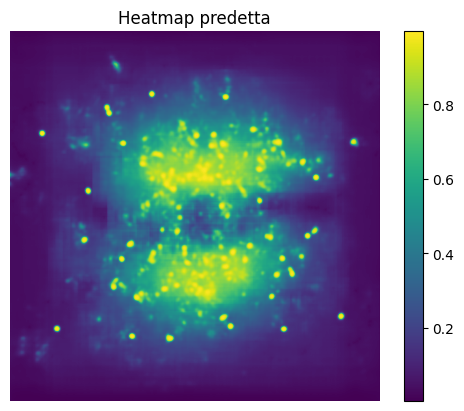

(800, 800)
Min: 0.0036014838
Max: 0.99614644
Mean: 0.24241248
[[0.01421772 0.01932094 0.0131532  ... 0.01176149 0.01686483 0.01410272]
 [0.02261849 0.02646114 0.01634235 ... 0.01428022 0.02054942 0.02027928]
 [0.01799326 0.02017931 0.01676511 ... 0.01366071 0.01295428 0.01363539]
 ...
 [0.01499656 0.01485479 0.01157241 ... 0.0094133  0.01054793 0.01217035]
 [0.01749721 0.01736067 0.00963923 ... 0.00874504 0.01488662 0.01673452]
 [0.01102947 0.01280048 0.00833872 ... 0.00780454 0.01240122 0.01135859]]


In [3]:
img_path = '/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px/images/val/event_8.npy'

img = np.load(img_path)  # shape atteso (H, W)
img = img.astype(np.float32)  # assicurati che sia in float32
img_tensor = torch.from_numpy(img).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    outputs = model(img_tensor)  # shape attesa (1, 1, H, W)
    outputs = torch.sigmoid(outputs)  # applica sigmoid per ottenere valori tra 0 e 1

outputs = outputs.squeeze(0).squeeze(0).cpu().numpy()  # rimuovi dimensioni non necessarie

plt.imshow(outputs)
plt.title("Heatmap predetta")
plt.colorbar()
plt.axis('off')
plt.show()
plt.imsave("heatmap_predetta.png", outputs)

print(outputs.shape)
print("Min:", outputs.min())
print("Max:", outputs.max())
print("Mean:", outputs.mean())
print(outputs)

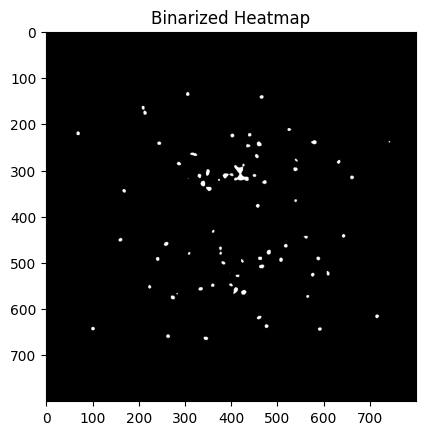

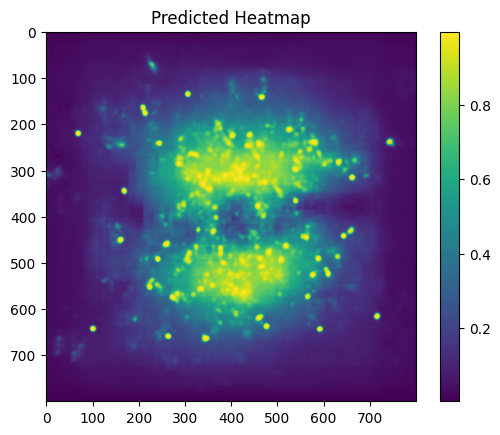

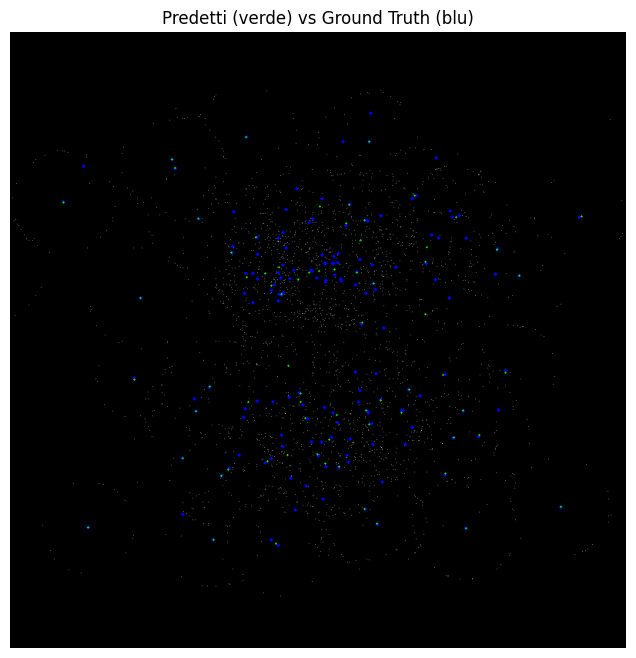

Threshold in pixels: 8 ==> precision: 0.8571, recall: 0.3846, f1-score: 0.5310


In [4]:
from UNet import infer_keypoints_from_image, img_kp_pred_and_gr, compute_pck_metrics, load_keypoints_from_csv

heatmap, keypoints_and_cov, time = infer_keypoints_from_image(img_path, model, device=device, show_mask=True, threshold=0.97, npy=True, sigmoid=True)

keypoints = [kp for kp, cov in keypoints_and_cov]
keypoints_gt = load_keypoints_from_csv('/user/gr1/delphi/dghezzi/SharedDataset_22500_2500_150_175_npy/UNet/800px/centers/val/event_8_centers.csv')
img_kp_pred_and_gr(keypoints_pred=keypoints, keypoints_gt=keypoints_gt, img_path=img_path)
pck_metrics = compute_pck_metrics(keypoints, keypoints_gt, thresholds=[8])
print(f'Threshold in pixels: 8 ==> precision: {pck_metrics[0][0]:.4f}, recall: {pck_metrics[1][0]:.4f}, f1-score: {pck_metrics[2][0]:.4f}')

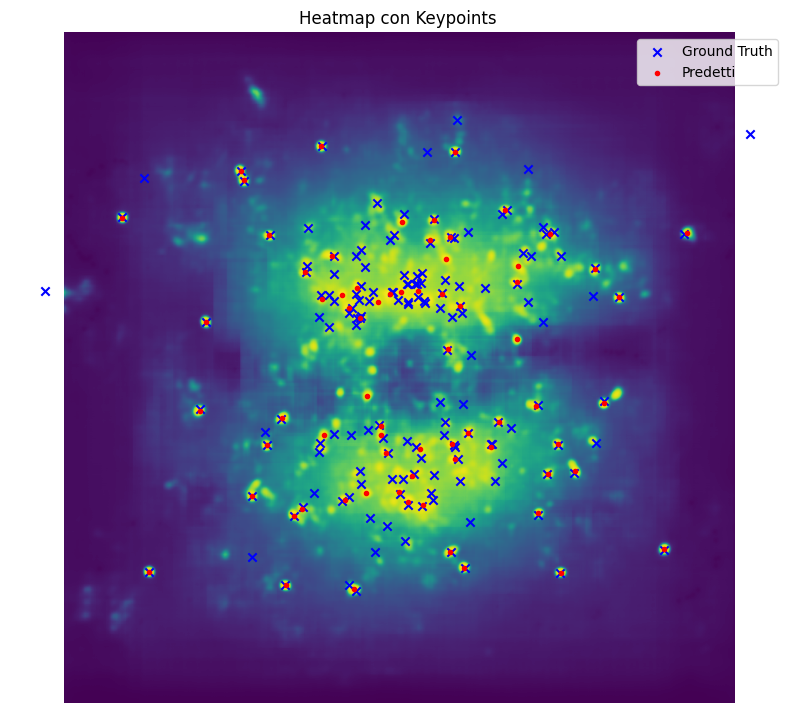

In [5]:
# sovrapponi heatmap e keypoints predetti
plt.figure(figsize=(10, 10))
plt.imshow(outputs, cmap='viridis')
plt.scatter(*zip(*keypoints_gt), c='blue', marker='x', label='Ground Truth')
plt.scatter(*zip(*keypoints), c='red', marker='.', label='Predetti')
plt.title("Heatmap con Keypoints")
plt.axis('off')
plt.legend()
plt.show()

In [5]:
coeff_bin_thresholds = np.arange(0.92, 1.00, 0.001)
f1_2px = []
f1_4px = []
f1_6px = []

for i in coeff_bin_thresholds:
    heatmap, keypoints_and_cov, time = infer_keypoints_from_image(img_path, model, device=device, show_mask=False, threshold=i, npy=True, sigmoid=True)
    keypoints = [kp for kp, cov in keypoints_and_cov]
    #img_kp_pred_and_gr(keypoints_pred=keypoints, keypoints_gt=keypoints_gt, img_path=img_path)
    prec, recall, f1 = compute_pck_metrics(keypoints_gt, keypoints, thresholds=[2,4,6])
    f1_2px.append(f1[0])
    f1_4px.append(f1[1])
    f1_6px.append(f1[2])
    print(f"Coefficient Binary Threshold: {i:.2f}")
    print(f"keypoints predicted: {len(keypoints)}, keypoints ground truth: {len(keypoints_gt)}, ratio: {len(keypoints)/len(keypoints_gt):.2f}")
    print(f"Metrics Threshold 2px: prec = {prec[0]:.3f}, recall = {recall[0]:.3f}, f1 = {f1[0]:.3f}")
    print(f"Metrics Threshold 4px: prec = {prec[1]:.3f}, recall = {recall[1]:.3f}, f1 = {f1[1]:.3f}")
    print(f"Metrics Threshold 6px: prec = {prec[2]:.3f}, recall = {recall[2]:.3f}, f1 = {f1[2]:.3f}")
    print('')

Coefficient Binary Threshold: 0.92
keypoints predicted: 90, keypoints ground truth: 172, ratio: 0.52
Metrics Threshold 2px: prec = 0.389, recall = 0.203, f1 = 0.267
Metrics Threshold 4px: prec = 0.700, recall = 0.366, f1 = 0.481
Metrics Threshold 6px: prec = 0.789, recall = 0.413, f1 = 0.542

Coefficient Binary Threshold: 0.92
keypoints predicted: 91, keypoints ground truth: 172, ratio: 0.53
Metrics Threshold 2px: prec = 0.385, recall = 0.203, f1 = 0.266
Metrics Threshold 4px: prec = 0.703, recall = 0.372, f1 = 0.487
Metrics Threshold 6px: prec = 0.802, recall = 0.424, f1 = 0.555

Coefficient Binary Threshold: 0.92
keypoints predicted: 90, keypoints ground truth: 172, ratio: 0.52
Metrics Threshold 2px: prec = 0.378, recall = 0.198, f1 = 0.260
Metrics Threshold 4px: prec = 0.711, recall = 0.372, f1 = 0.489
Metrics Threshold 6px: prec = 0.811, recall = 0.424, f1 = 0.557

Coefficient Binary Threshold: 0.92
keypoints predicted: 90, keypoints ground truth: 172, ratio: 0.52
Metrics Threshold

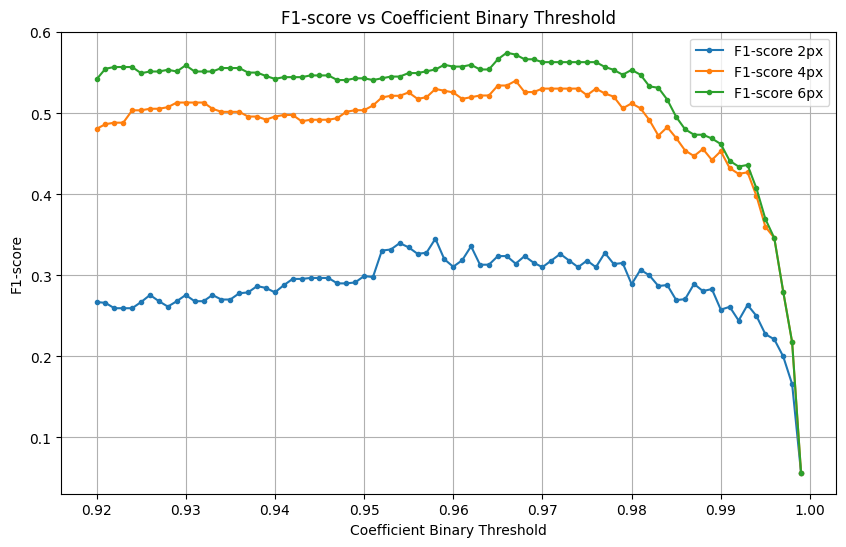

In [6]:
# grafico delle f1-score
plt.figure(figsize=(10, 6))
plt.plot(coeff_bin_thresholds, f1_2px, label='F1-score 2px', marker='.')
plt.plot(coeff_bin_thresholds, f1_4px, label='F1-score 4px', marker='.')
plt.plot(coeff_bin_thresholds, f1_6px, label='F1-score 6px', marker='.')
plt.title('F1-score vs Coefficient Binary Threshold')
plt.xlabel('Coefficient Binary Threshold')
plt.ylabel('F1-score')
plt.grid()
plt.legend()
plt.savefig("f1_scores_vs_threshold.png")
plt.show()

0.97 sembra essere il valore migliore di threshold per la maschera binaria

In [9]:
from UNet import inference_dataset

# Esegui inferenza su un intero dataset
dataset_path = '/user/gr1/delphi/dghezzi/UNet/UNet_dataset/500test_npy'
model_path = '/user/gr1/delphi/dghezzi/UNet/Models/Model_92000_8000_160_180_npy/best_unet.pth'
output_dir = '/user/gr1/delphi/dghezzi/UNet/Models/Model_92000_8000_160_180_npy/output_inference'

inference_dataset(dataset_path, output_dir, model_path, device=device)

{'precision': [0.5102134793814711, 0.8001728064526975, 0.8831712245240693],
 'recall': [0.19936246297372023, 0.3128253709185009, 0.3452618687857646],
 'f1': [0.2861988243764627, 0.4490215475982013, 0.49558117871194995],
 'stdmean_f1': [0.001682510544197448,
  0.0016339361902717195,
  0.0015040841604765202],
 'inference_time': 0.004081446170806885}

In [ ]:
import os

output_metrics_file = os.path.join(output_dir, 'metrics_log.txt')
with open(output_metrics_file, 'w') as f:
    # Intestazione colonne
    f.write("CoeffBinThresh\tPixelThresh\tPrecision\tRecall\tF1\n")

    for i in coeff_bin_thresholds:
        print(f"==> Coefficient Binary Threshold: {i:.3f}")

        output_subdir = f"{output_dir}/thresh_{i:.3f}".replace('.', '_')

        metrics = inference_dataset(
            datapath=dataset_path,
            output_path=output_subdir,
            model_path=model_path,
            device='cuda',
            pixel_thresholds=[2, 3, 4, 5, 6],
            attention_model=True,
            threshold=i,
            show_mask=False
        )

        # Cicla sulle soglie pixel e scrivi riga per ogni soglia
        for idx, px_thresh in enumerate([2, 3, 4, 5, 6]):
            precision = metrics['precision'][idx]
            recall = metrics['recall'][idx]
            f1 = metrics['f1'][idx]
            f.write(f"{i:.3f}\t{px_thresh}\t{precision:.4f}\t{recall:.4f}\t{f1:.4f}\n")

            print(f"Threshold {px_thresh}px: Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

        print("")
        

==> Coefficient Binary Threshold: 0.920
Threshold 2px: Precision: 0.394, Recall: 0.188, F1: 0.254
Threshold 3px: Precision: 0.560, Recall: 0.267, F1: 0.361
Threshold 4px: Precision: 0.636, Recall: 0.304, F1: 0.410
Threshold 5px: Precision: 0.688, Recall: 0.328, F1: 0.443
Threshold 6px: Precision: 0.737, Recall: 0.351, F1: 0.475

==> Coefficient Binary Threshold: 0.921
Threshold 2px: Precision: 0.395, Recall: 0.188, F1: 0.254
Threshold 3px: Precision: 0.562, Recall: 0.268, F1: 0.362
Threshold 4px: Precision: 0.638, Recall: 0.304, F1: 0.411
Threshold 5px: Precision: 0.690, Recall: 0.328, F1: 0.444
Threshold 6px: Precision: 0.739, Recall: 0.352, F1: 0.476

==> Coefficient Binary Threshold: 0.922
Threshold 2px: Precision: 0.396, Recall: 0.188, F1: 0.255
Threshold 3px: Precision: 0.565, Recall: 0.268, F1: 0.363
Threshold 4px: Precision: 0.640, Recall: 0.305, F1: 0.412
Threshold 5px: Precision: 0.692, Recall: 0.329, F1: 0.445
Threshold 6px: Precision: 0.741, Recall: 0.352, F1: 0.477

==> Coe

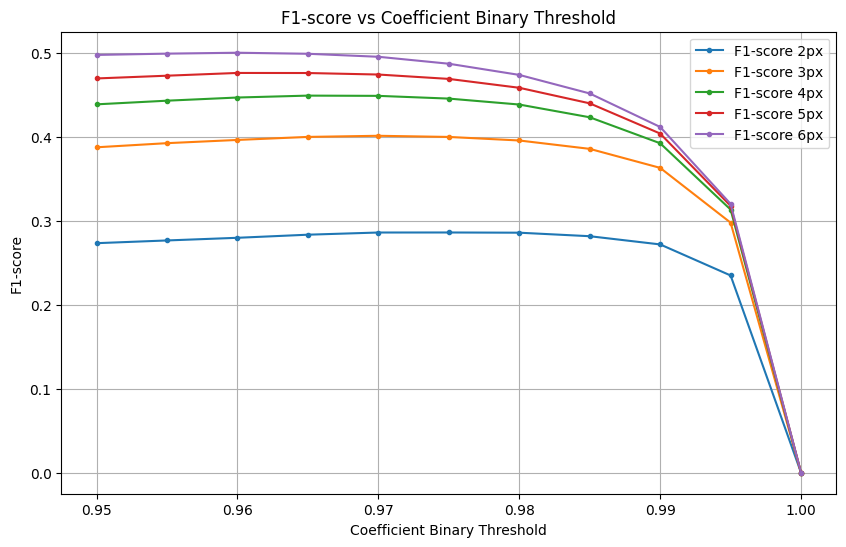

Average Inference Time: 3.98 ms


In [ ]:
# grafico delle f1-score
plt.figure(figsize=(10, 6))
plt.plot(coeff_bin_thresholds, f1_2px, label='F1-score 2px', marker='.')
plt.plot(coeff_bin_thresholds, f1_3px, label='F1-score 3px', marker='.')
plt.plot(coeff_bin_thresholds, f1_4px, label='F1-score 4px', marker='.')
plt.plot(coeff_bin_thresholds, f1_5px, label='F1-score 5px', marker='.')
plt.plot(coeff_bin_thresholds, f1_6px, label='F1-score 6px', marker='.')
plt.title('F1-score vs Coefficient Binary Threshold')
plt.xlabel('Coefficient Binary Threshold')
plt.ylabel('F1-score')
plt.grid()
plt.legend()
plt.savefig("f1_scores_vs_threshold_inference_dataset.png")
plt.show()

print(f"Average Inference Time: {np.mean(metrics['inference_time'])*1000:.2f} ms")

In [3]:
import os
from UNet import inference_dataset

output_dir = '/user/gr1/delphi/dghezzi/UNet/Models/Model_92000_8000_160_180_npy/output_studyRings'
model_path = '/user/gr1/delphi/dghezzi/UNet/Models/Model_92000_8000_160_180_npy/best_unet.pth'

precision_4px = []
recall_4px = []
f1_4px = []
inference_time_4px = []

output_metrics_file = os.path.join(output_dir, 'studyRings_metrics_log.txt')
with open(output_metrics_file, 'w') as f:
    # Intestazione colonne
    f.write("PixelThresh\tPrecision\tRecall\tF1\tInferenceTime\n")

    for N in np.arange(10, 200, 10):

        output_subdir = f"{output_dir}/{N}_rings".replace('.', '_')

        dataset_path = f'/user/gr1/delphi/dghezzi/UNet/UNet_dataset/study_rings_npy/{N}_rings'

        metrics = inference_dataset(
            datapath=dataset_path,
            output_path=output_subdir,
            model_path=model_path,
            device='cuda',
            pixel_thresholds=[2, 3, 4, 5, 6],
            attention_model=True,
            threshold=0.97,
            show_mask=False
        )

        # Cicla sulle soglie pixel e scrivi riga per ogni soglia
        for idx, px_thresh in enumerate([2, 3, 4, 5, 6]):
            precision = metrics['precision'][idx]
            recall = metrics['recall'][idx]
            f1 = metrics['f1'][idx]
            inference_time = metrics['inference_time']
            f.write(f"{px_thresh}\t{precision:.4f}\t{recall:.4f}\t{f1:.4f}\t{inference_time:.6f}\n")
            
            if px_thresh == 4:
                precision_4px.append(precision)
                recall_4px.append(recall)
                f1_4px.append(f1)
                inference_time_4px.append(inference_time)

            print(f"Threshold {px_thresh}px: Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Inference Time: {inference_time:.6f}s")

        print("")

Threshold 2px: Precision: 0.852, Recall: 0.734, F1: 0.785, Inference Time: 0.059570s
Threshold 3px: Precision: 0.945, Recall: 0.814, F1: 0.870, Inference Time: 0.059570s
Threshold 4px: Precision: 0.965, Recall: 0.831, F1: 0.889, Inference Time: 0.059570s
Threshold 5px: Precision: 0.972, Recall: 0.837, F1: 0.896, Inference Time: 0.059570s
Threshold 6px: Precision: 0.978, Recall: 0.842, F1: 0.901, Inference Time: 0.059570s

Threshold 2px: Precision: 0.778, Recall: 0.639, F1: 0.699, Inference Time: 0.073139s
Threshold 3px: Precision: 0.899, Recall: 0.738, F1: 0.808, Inference Time: 0.073139s
Threshold 4px: Precision: 0.929, Recall: 0.763, F1: 0.835, Inference Time: 0.073139s
Threshold 5px: Precision: 0.940, Recall: 0.772, F1: 0.845, Inference Time: 0.073139s
Threshold 6px: Precision: 0.949, Recall: 0.780, F1: 0.853, Inference Time: 0.073139s

Threshold 2px: Precision: 0.712, Recall: 0.552, F1: 0.620, Inference Time: 0.085015s
Threshold 3px: Precision: 0.857, Recall: 0.665, F1: 0.746, Infe

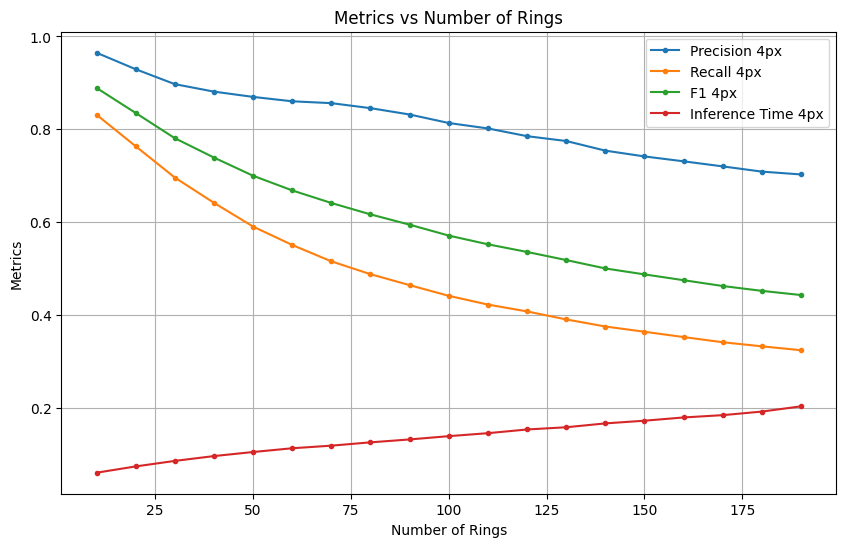

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(10, 200, 10), precision_4px, label='Precision 4px', marker='.')
plt.plot(np.arange(10, 200, 10), recall_4px, label='Recall 4px', marker='.')
plt.plot(np.arange(10, 200, 10), f1_4px, label='F1 4px', marker='.')
plt.plot(np.arange(10, 200, 10), inference_time_4px, label='Inference Time 4px', marker='.')
plt.title('Metrics vs Number of Rings')
plt.xlabel('Number of Rings')
plt.ylabel('Metrics')
plt.grid()
plt.legend()
plt.savefig('studyRings_metrics_plot.png')
plt.show()